## Imports

In [157]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import datetime
import CovidAPI

## Data

In [140]:
def getDataPoints(X, y, countryData):
    cases = []
    # Only get relevant data
    for d in countryData:
        cases.append((d["Confirmed"], d["Date"].split("T")[0]))
        
    # Create data points for X and corresponding y
    # For each datapoint 0:N-14
    for i in range(len(cases)-14):
        timeRange = []
        # For selected date n:n+13
        for k in range(14):
            timeRange.append(cases[i+k][0])
        X.append(timeRange)
        # Target is 15th day
        y.append(cases[i+14][0])
    return X, y
        
    
X = []
y = []

api = CovidAPI.API()
#data = api.getDayOneCountry("Madagascar")
#data = api.getAllCountryCases()

for d in data:
    X, y = getDataPoints(X, y, d)
    
X = np.asarray(X)#.reshape((len(X), len(X[0]), 1))
y = np.asarray(y)#.reshape((len(y), 1))

dim = X.shape[1]
N = X.shape[0]

print("X dimensions:", dim)
print("No. data points:", N)

X dimensions: 14
No. data points: 40222


In [184]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=False)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (26948, 14)
y_train shape: (26948,)


## LSTM

In [195]:
from tensorflow.keras.layers import Dense, Dropout, Input, LSTM
from tensorflow.keras.models import Model, Sequential

tf.keras.backend.clear_session()

#model = Sequential()
#model.add()
#model.add(LSTM(14, input_shape=(dim), return_sequences=True, stateful=False))
#model.add(LSTM(100, input_shape=(dim), return_sequences=False, stateful=False))
#model.add(Dense(1, activation='linear'))
#model.compile(loss='mse', optimizer='adam')

# model = Sequential()
# model.add(LSTM(14, activation='relu', return_sequences=True, input_shape=(dim,1)))
# model.add(LSTM(14, activation='relu'))
# model.add(Dropout(0.3))
# model.add(Dense(1, activation='linear'))

#define the learning rate
optimizer = keras.optimizers.Adam(lr=learning_rate)

#compile model
model.compile(optimizer=optimizer, loss='mae')

input_layer = Input(shape=(dim))
dense1 = Dense(60, activation='linear')(input_layer)
dense2 = Dense(100, activation='linear')(dense1)
dropout_layer = Dropout(0.2)(dense2)
output_layer = Dense(1, activation='linear')(dropout_layer)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss=tf.keras.losses.MeanAbsolutePercentageError(), optimizer='adam')
model.summary()


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 14)]              0         
_________________________________________________________________
dense (Dense)                (None, 60)                900       
_________________________________________________________________
dense_1 (Dense)              (None, 100)               6100      
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 7,101
Trainable params: 7,101
Non-trainable params: 0
_________________________________________________________________


In [196]:
model.fit(X_train, y_train, batch_size=5, epochs=20,
          validation_data=(X_test, y_test), shuffle=True)

Epoch 1/20
5390/5390 [==============================] - 4s 818us/step - loss: 8.2942 - val_loss: 7.8294
Epoch 2/20
5390/5390 [==============================] - 4s 820us/step - loss: 7.0063 - val_loss: 2.4209
Epoch 3/20
5390/5390 [==============================] - 4s 819us/step - loss: 6.7598 - val_loss: 7.5588
Epoch 4/20
5390/5390 [==============================] - 4s 818us/step - loss: 6.6890 - val_loss: 2.9944
Epoch 5/20
5390/5390 [==============================] - 4s 827us/step - loss: 6.5671 - val_loss: 5.8908
Epoch 6/20
5390/5390 [==============================] - 4s 824us/step - loss: 6.6255 - val_loss: 8.2810
Epoch 7/20
5390/5390 [==============================] - 4s 818us/step - loss: 6.5627 - val_loss: 3.5735
Epoch 8/20
5390/5390 [==============================] - 4s 828us/step - loss: 6.5855 - val_loss: 3.5612
Epoch 9/20
5390/5390 [==============================] - 4s 797us/step - loss: 6.6268 - val_loss: 2.9028
Epoch 10/20
5390/5390 [==============================] - 4s 826u

(13274, 14)
13274


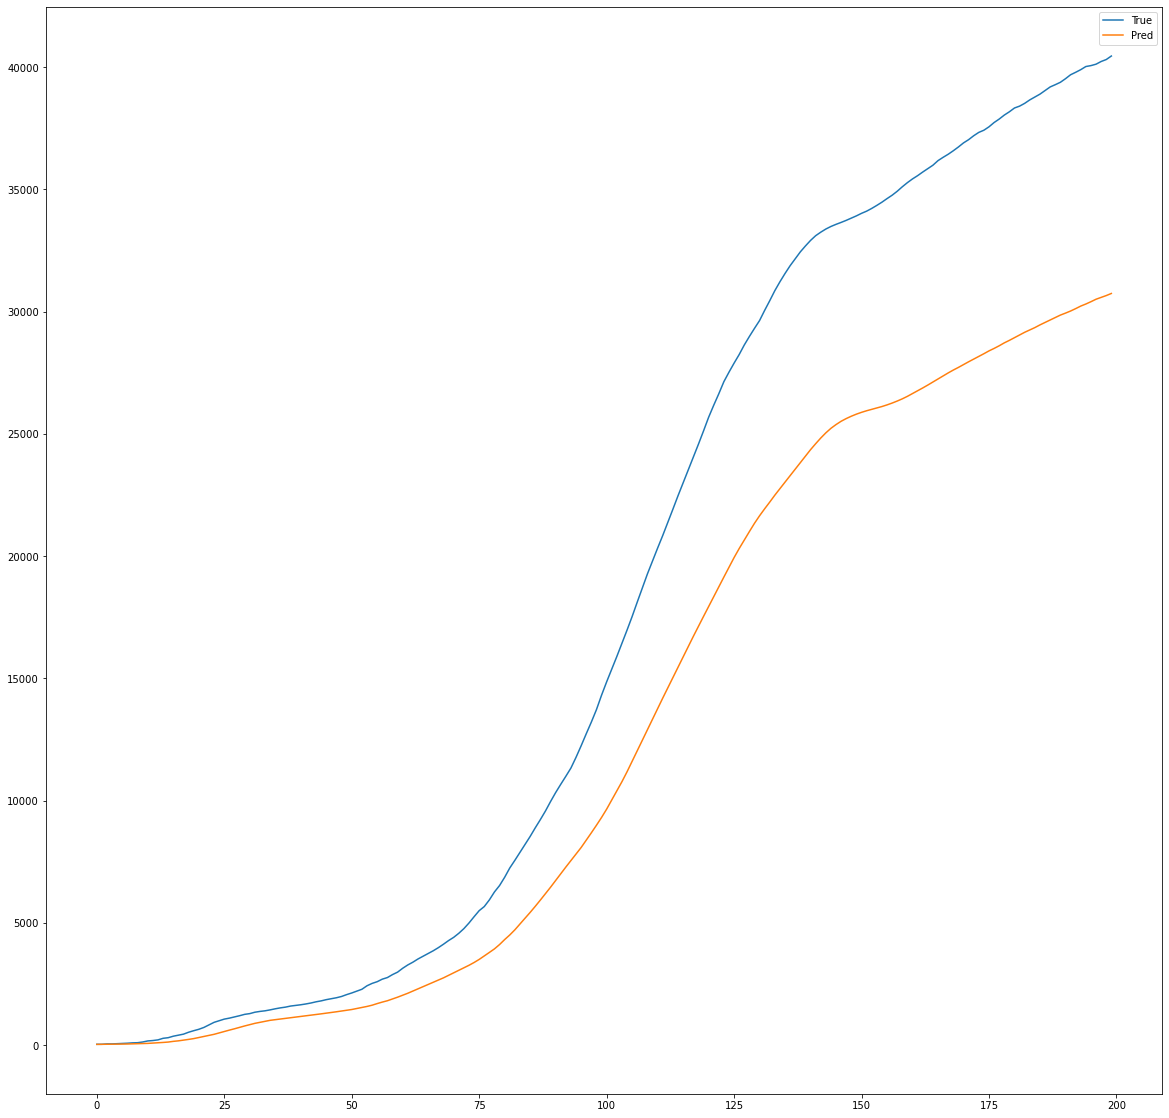

In [192]:
print(X_test.shape)
y_pred = model.predict(X_test)
print(y_test.shape[0])

n = 200
splitP = 1670
plt.figure(figsize=(20,20))
plt.plot(np.arange(n), y_test[splitP:splitP+n], label="True")
plt.plot(np.arange(n), y_pred[splitP:splitP+n], label="Pred")
plt.legend()
plt.show()